# Notebook para o PAN - Atribuição Autoral - 2018

In [1]:
%matplotlib inline
#python basic libs
import os;
from os.path import join as pathjoin;

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import UndefinedMetricWarning
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)

import re;
import json;
import codecs;
from collections import defaultdict;

from pprint import pprint
from time import time
import logging


#data analysis libs
import numpy as np;
import pandas as pd;
from pandas.plotting import scatter_matrix;
import matplotlib.pyplot as plt;
import random;

#machine learning libs
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

#preprocessing and transformation
from sklearn import preprocessing
from sklearn.preprocessing import normalize, MaxAbsScaler, RobustScaler;
from sklearn.decomposition import PCA;

from sklearn.base import BaseEstimator, ClassifierMixin

#classifiers
from sklearn import linear_model;
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.neural_network import MLPClassifier

 
#
from sklearn import feature_selection;
from sklearn import ensemble;

from sklearn.model_selection import train_test_split;
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#model valuation
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score;

In [2]:
import seaborn as sns;
sns.set(color_codes=True);

In [3]:
import spacy
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [4]:
import platform;
import sklearn;
import scipy;

print("|%-15s|%-40s|"%("PACK","VERSION"))
print("|%-15s|%-40s|"%('-'*15,'-'*40))
print('\n'.join(
    "|%-15s|%-40s|" % (pack, version)
    for pack, version in
    zip(['SO','NumPy','SciPy','Scikit-Learn','seaborn','spacy'],
        [platform.platform(), np.__version__, scipy.__version__, sklearn.__version__, sns.__version__, spacy.__version__])

))

|PACK           |VERSION                                 |
|---------------|----------------------------------------|
|SO             |Darwin-18.2.0-x86_64-i386-64bit         |
|NumPy          |1.15.4                                  |
|SciPy          |1.1.0                                   |
|Scikit-Learn   |0.20.1                                  |
|seaborn        |0.9.0                                   |
|spacy          |2.0.16                                  |


In [5]:
np.set_printoptions(precision=4)
pd.options.display.float_format = '{:,.4f}'.format

In [6]:
#externalizing codes that is used in many notebooks and it is not experiment specific
import pan
#convert a sparse matrix into a dense for being used on PCA
from sklearnExtensions import DenseTransformer;

#convert an array of text into an array of tokenized texts each token must contain text, tag_, pos_, dep_
from sklearnExtensions import POSTagTransformer

### paths configuration

In [7]:
baseDir = '/Users/joseeleandrocustodio/Dropbox/mestrado/02 - Pesquisa/code';

inputDir= pathjoin(baseDir,'pan18aa');
outputDir= pathjoin(baseDir,'out',"oficial");
if not os.path.exists(outputDir):
    os.mkdir(outputDir);

## loading the dataset

In [8]:
problems = pan.readCollectionsOfProblems(inputDir);

In [9]:
pd.DataFrame(problems)

,candidates,candidates_folder_count,encoding,language,problem,unknown
0,"[(graceful ones.\n\n""One more,"" Marvelous said...",20,UTF-8,en,problem00001,"[(after all, his best friends. And what in the..."
1,"[(a mission.""\n\nJensen just raises an eyebrow...",5,UTF-8,en,problem00002,"[(“Potter was attractive,” Draco thought, sigh..."
2,[(qui l'avait tué mais tout était de la faute ...,20,UTF-8,fr,problem00003,[(son réveil. Sa main pulse et Draco frotte l'...
3,[(. Le canapé est vide et lorsqu'il passe deva...,5,UTF-8,fr,problem00004,"[(abasourdie.\n\nTout d'abord, elle crut que s..."
4,"[(Eppure lui la mappa l’aveva stampata, dannaz...",20,UTF-8,it,problem00005,[(– Oh. Cazzo.\nSirius era così sconvolto che ...
5,[(Yato ha trovato una lettera sul suo comodino...,5,UTF-8,it,problem00006,"[(così la tua vista, Moony?\n– Cercavo di esse..."
6,[(zmienił zdanie. Niech się stworzonko pobawi....,20,UTF-8,pl,problem00007,"[(dawniej pełna radości i ciepła, a teraz wiec..."
7,"[(Słowem, które Sherlock najczęściej słyszał w...",5,UTF-8,pl,problem00008,"[(, uderzającego o żebra niczym dzwon- niemal ..."
8,[(pero no lo ama como ama a Guignol –explicó e...,20,UTF-8,sp,problem00009,[(–La nariz puntiaguda del elfo casi rozaba el...
9,"[(incapaz de señalar un momento exacto, un pun...",5,UTF-8,sp,problem00010,[(tan parecidas hizo que su trasero latiese de...


In [10]:
def cachingPOSTAG(problem, taggingVersion='TAG'):
    import json;
    print ("Tagging: %s,  language: %s, " %(problem['problem'],problem['language']), end=' ');
    
    if not os.path.exists('POSTAG_cache'):
        os.makedirs('POSTAG_cache');
    
    _id = problem['problem']+problem['language'];
    filename = os.path.join('POSTAG_cache',taggingVersion+'_'+_id+'.json')
    if not os.path.exists(filename):
        lang = problem['language'];
        if lang == 'sp':
            lang = 'es';
        elif lang =='pl':
            print(lang, ' not supported');
            return ;

        train_docs, train_labels, _   = zip(*problem['candidates'])
        problem['training_docs_size'] = len(train_docs);
        test_docs, _, test_filename   = zip(*problem['unknown'])

        t0 = time()
        tagger = POSTagTransformer(language=lang);
        train_docs = tagger.fit_transform(train_docs);
        test_docs = tagger.fit_transform(test_docs);
        
        print("Annotation time %0.3fs" % (time() - t0))
        
        with open(filename,'w') as f:
            json.dump({
                'train':train_docs,
                'train_labels':train_labels,
                'test':test_docs,
                'test_filename':test_filename
            },f);
    else:
        with open(filename,'r') as f:
            data = json.load(f);

            train_docs = data['train'];
            train_labels = data['train_labels'];
            test_docs  = data['test'];
            test_filename = data['test_filename'];
    print('tagged')
    return train_docs, train_labels, test_docs, test_filename;

for problem in problems:
    cachingPOSTAG(problem)

Tagging: problem00001,  language: en,  tagged
Tagging: problem00002,  language: en,  tagged
Tagging: problem00003,  language: fr,  tagged
Tagging: problem00004,  language: fr,  tagged
Tagging: problem00005,  language: it,  tagged
Tagging: problem00006,  language: it,  tagged
Tagging: problem00007,  language: pl,  pl  not supported
Tagging: problem00008,  language: pl,  pl  not supported
Tagging: problem00009,  language: sp,  tagged
Tagging: problem00010,  language: sp,  tagged


In [11]:
train_docs, train_labels, test_docs, test_filename = cachingPOSTAG(problem)

Tagging: problem00010,  language: sp,  tagged


In [12]:
class FilterTagTransformer(BaseEstimator):
    def __init__(self,token='POS', parts=None):
        self.token = token;
        self.parts = parts;
            

    def transform(self, X, y=None):
        """ Return An array of tokens 
        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_tokens]
            Array documents, where each document consists of a list of node
            and each node consist of a token and its correspondent tag
            
            [
            [('a','TAG1'),('b','TAG2')],
            [('a','TAG1')]
            ]
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        t0 = time()
        print('start filter', end=' ')
        if self.token == 'TAG':
            X = [' '.join([d[1].split('__')[0] for d in doc]) for doc in X]
        elif self.token == 'POS':
            if self.parts is None:
                X = [' '.join([d[2] for d in doc]) for doc in X];
            else:
                X = [' '.join([d[0] for d in doc if d[2] in self.parts]) for doc in X]
        elif self.token == 'DEP':
            X = [' '.join([d[3] for d in doc]) for doc in X]
        elif self.token == 'word_POS':
            if self.parts is None:
                X = [' '.join([d[0]+'/'+d[2] for d in doc]) for doc in X]
        elif self.token == 'filter':
            X = [' '.join([d[0] for d in doc if d[2] in self.parts]) for doc in X]
        else:
            X = [' '.join([d[0] for d in doc]) for doc in X]
        
        print(" %0.3fs" % (time() - t0))
        return np.array(X);       

    def fit(self, X, y=None):
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        return self.transform(X=X, y=y)

### analisando os demais parametros

In [13]:
def runML(problem):
    print ("\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']), end=' ');
    
    lang = problem['language'];
    if lang == 'sp':
        lang = 'es';
    elif lang =='pl':
        print(lang, ' not supported');
        return None,None,None,None;
    
    train_docs, train_labels, test_docs, test_filename = cachingPOSTAG(problem)

    t0 = time()
    
    pipeline = Pipeline([
        ('filter',FilterTagTransformer(token='DEP')),
        ('vect', CountVectorizer(
                        analyzer='word',
                        min_df=0.01,
                        lowercase=False
                )),
        ('tfidf',  TfidfTransformer()),
        ('scaler', MaxAbsScaler()),
        ('dense',  DenseTransformer()),
        ('transf', PCA(0.999)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])
    
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__ngram_range' :((1,1),(1,2),(1,3),(1,5)),
        'tfidf__sublinear_tf':(True, False),
        'tfidf__norm':('l1','l2'),
        'clf__C':(0.1,1,10),
    }
    
    grid_search = GridSearchCV(pipeline,
                               parameters,
                               cv=4,
                               iid=False,
                               n_jobs=-1,
                               verbose=False,
                               scoring='f1_macro')
    
    t0 = time()
    grid_search.fit(train_docs, train_labels)
    print("Gridsearh %0.3fs" % (time() - t0), end=' ')

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    
    
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append({'unknown-text': test_filename[i],'predicted-author': v})
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
    
    
    #calculating the performance using PAN evaluation code
    f1,precision,recall,accuracy=pan.evaluate(
                pathjoin(inputDir, problem['problem'], 'ground-truth.json'),
                answerFile)
    
    return {
                'problem-name'  :       problem['problem'],
                "language"      :       problem['language'],
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3),
                
        }, grid_search.cv_results_,best_parameters, grid_search.best_estimator_;

In [14]:
result = [];
cv_result = [];
best_parameters = [];
estimators = [];
for problem in problems:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore");
        r, c, b, e = runML(problem);
        if r is None:
            continue;
        result.append(r);
        cv_result.append(c);
        estimators.append(e);
        b['problem'] = problem['problem'];
        best_parameters.append(b);


Problem: problem00001,  language: en,  Tagging: problem00001,  language: en,  tagged
start filter  0.020s
Gridsearh 526.215s Best score: 0.472
Best parameters set:
	clf__C: 10
	tfidf__norm: 'l1'
	tfidf__sublinear_tf: False
	vect__ngram_range: (1, 5)
start filter  0.013s
start filter  0.017s

Problem: problem00002,  language: en,  Tagging: problem00002,  language: en,  tagged
start filter  0.005s
Gridsearh 131.409s Best score: 0.775
Best parameters set:
	clf__C: 0.1
	tfidf__norm: 'l1'
	tfidf__sublinear_tf: False
	vect__ngram_range: (1, 1)
start filter  0.004s
start filter  0.003s

Problem: problem00003,  language: fr,  Tagging: problem00003,  language: fr,  tagged
start filter  0.013s
Gridsearh 577.729s Best score: 0.520
Best parameters set:
	clf__C: 1
	tfidf__norm: 'l2'
	tfidf__sublinear_tf: True
	vect__ngram_range: (1, 3)
start filter  0.011s
start filter  0.009s

Problem: problem00004,  language: fr,  Tagging: problem00004,  language: fr,  tagged
start filter  0.004s
Gridsearh 163.1

In [15]:
df=pd.DataFrame(result)[['problem-name',
                     "language",
                     'macro-f1','macro-precision','macro-recall' ,'micro-accuracy']]

In [16]:
df

,problem-name,language,macro-f1,macro-precision,macro-recall,micro-accuracy
0,problem00001,en,0.3780,0.3740,0.5570,0.5520
1,problem00002,en,0.3110,0.3620,0.3270,0.4290
2,problem00003,fr,0.3490,0.3780,0.3830,0.3670
3,problem00004,fr,0.4090,0.4910,0.4770,0.4760
4,problem00005,it,0.2210,0.2370,0.3170,0.2500
5,problem00006,it,0.4990,0.5410,0.7250,0.5650
6,problem00009,sp,0.4180,0.4020,0.5510,0.4530
7,problem00010,sp,0.4220,0.4390,0.4390,0.5310


In [17]:
df[['macro-f1']].mean()

macro-f1   0.3759
dtype: float64

In [18]:
languages={
    'en':'inglesa',
    'sp':'espanhola',
    'it':'italiana',
    'pl':'polonesa',
    'fr':'francesa'
}

In [19]:
cv_result2 = [];
dfCV = pd.DataFrame();
for i, c in enumerate(cv_result):
    temp = pd.DataFrame(c);
    temp['problem'] = int(re.sub('\D','',result[i]['problem-name']));
    temp['language'] = languages[result[i]['language']]
    dfCV = dfCV.append(temp);

for p in [
    'mean_test_score','std_test_score','mean_train_score',   
    'split0_test_score',
    'split1_test_score',
    'split2_test_score']:
    dfCV[p]=dfCV[p].astype(np.float32);

    
dfCV =dfCV[[
    'problem',
    'language',
    'rank_test_score',
    'param_vect__ngram_range',
    'param_tfidf__sublinear_tf',
    'param_tfidf__norm',
    'param_clf__C',
    'mean_test_score',   
    'std_test_score',

    'split0_test_score',
    'split1_test_score',
    'split2_test_score',

    'mean_score_time',
    'mean_fit_time',
    'std_fit_time',
    'std_score_time',
    'std_train_score',
]];

dfCV.rename(columns={
    'param_vect__ngram_range':'ngram_range',
    'param_tfidf__sublinear_tf':'sublinear_tf',
    'param_tfidf__smooth_idf':'smooth_idf',
    'param_tfidf__norm':'norm',
    'param_clf__C':'regularization',
},inplace=True);

#print('\',\n\''.join(dfCV.columns))


In [20]:
dfCV.head()

,problem,language,rank_test_score,ngram_range,sublinear_tf,norm,regularization,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,mean_score_time,mean_fit_time,std_fit_time,std_score_time,std_train_score
0,1,inglesa,46,"(1, 1)",True,l1,0.1000,0.1482,0.0406,0.2036,0.1576,0.0900,0.0247,0.0761,0.0035,0.0071,0.0473
1,1,inglesa,36,"(1, 2)",True,l1,0.1000,0.4107,0.1421,0.2769,0.3550,0.3610,0.0430,0.1537,0.0192,0.0109,0.0000
2,1,inglesa,3,"(1, 3)",True,l1,0.1000,0.4691,0.0843,0.3483,0.5119,0.4412,0.0742,0.2990,0.0141,0.0198,0.0000
3,1,inglesa,11,"(1, 5)",True,l1,0.1000,0.4496,0.1104,0.3321,0.4786,0.3710,0.2253,1.5818,0.2491,0.0754,0.0000
4,1,inglesa,42,"(1, 1)",False,l1,0.1000,0.2472,0.0504,0.2687,0.1740,0.2343,0.0241,0.0740,0.0037,0.0060,0.0427


## Saving the model

In [21]:
dfCV.to_csv('PANAA2018_POSDEP.csv', index=False)

In [22]:
dfCV = pd.read_csv('PANAA2018_POSDEP.csv', na_values='')

In [23]:
import pickle;
with open("PANAA2018_POSDEP.pkl","wb") as f:
    pickle.dump(estimators,f)

In [24]:
import pickle;
with open("PANAA2018_POSDEP.pkl",'rb') as f:
    estimators = pickle.load(f);

## understanding the model with reports

Podemos ver que para um mesmo problema mais de uma configuração é possível

In [25]:
print(' | '.join(best_parameters[0]['vect'].get_feature_names()[0:20]))

ROOT | ROOT ROOT | ROOT ROOT ROOT | ROOT ROOT ROOT ROOT | ROOT ROOT ROOT nsubj | ROOT ROOT ROOT punct | ROOT ROOT ROOT punct ROOT | ROOT ROOT ROOT punct compound | ROOT ROOT ROOT punct npadvmod | ROOT ROOT ROOT punct nsubj | ROOT ROOT ROOT punct punct | ROOT ROOT advmod | ROOT ROOT advmod ROOT | ROOT ROOT advmod aux | ROOT ROOT advmod aux nsubj | ROOT ROOT advmod nsubj | ROOT ROOT advmod nsubj ROOT | ROOT ROOT advmod punct | ROOT ROOT attr | ROOT ROOT attr ROOT


In [26]:
(dfCV[dfCV.rank_test_score == 1]).drop_duplicates()[
    ['problem',
     'language',
    'mean_test_score',
    'std_test_score',
    'ngram_range',
    'sublinear_tf',
     'norm']
].sort_values(by=[
    'problem',
    'mean_test_score',
    'std_test_score',
    'ngram_range',
    'sublinear_tf'
], ascending=[True, False,True,False,False])

,problem,language,mean_test_score,std_test_score,ngram_range,sublinear_tf,norm
39,1,inglesa,0.4723,0.1217,"(1, 5)",False,l1
52,2,inglesa,0.7750,0.1479,"(1, 1)",False,l1
122,3,francesa,0.5198,0.0899,"(1, 3)",True,l2
150,4,francesa,0.7383,0.1597,"(1, 3)",False,l1
166,4,francesa,0.7383,0.1597,"(1, 3)",False,l1
182,4,francesa,0.7383,0.1597,"(1, 3)",False,l1
226,5,italiana,0.4302,0.0894,"(1, 3)",True,l1
242,6,italiana,0.7783,0.1654,"(1, 3)",True,l1
258,6,italiana,0.7783,0.1654,"(1, 3)",True,l1
315,9,espanhola,0.4553,0.0644,"(1, 5)",True,l2


In [27]:
dfCV.pivot_table(
            index=['problem','language', 'norm','sublinear_tf'],
            columns=['ngram_range','regularization'],
            values='mean_test_score'
        )

ngram_range                          (1, 1)                  (1, 2)          \
regularization                      0.1000  1.0000  10.0000 0.1000  1.0000    
problem language  norm sublinear_tf                                           
1       inglesa   l1   False         0.2472  0.3343  0.3094  0.4419  0.4181   
                       True          0.1482  0.1378  0.1509  0.4107  0.4186   
                  l2   False         0.2649  0.3243  0.3346  0.4462  0.4342   
                       True          0.1509  0.1440  0.1609  0.4230  0.4146   
2       inglesa   l1   False         0.7750  0.6800  0.5919  0.6100  0.6317   
                       True          0.4450  0.4043  0.4510  0.5369  0.5369   
                  l2   False         0.7533  0.6783  0.5800  0.7417  0.6967   
                       True          0.4450  0.4210  0.4510  0.5369  0.5369   
3       francesa  l1   False         0.1999  0.2705  0.2951  0.4211  0.3967   
                       True          0.1194  0.1546  0.2031  0.3886  0.3981   
                  l2   False         0.2128  0.2457  0.3103  0.4278  0.4144   
                       True          0.1189  0.1567  0.2094  0.4102  0.4057   
4       francesa  l1   False         0.5783  0.5300  0.4900  0.5750  0.5733   
                       True          0.4067  0.4600  0.4717  0.6067  0.6067   
                  l2   False         0.5769  0.5717  0.5236  0.6100  0.6083   
                       True          0.4067  0.4600  0.4717  0.6317  0.6317   
5       italiana  l1   False         0.2509  0.2964  0.3171  0.2767  0.2796   
                       True          0.1196  0.1664  0.1690  0.2699  0.2720   
                  l2   False         0.2235  0.2773  0.3354  0.3097  0.3089   
                       True          0.1221  0.1408  0.1690  0.2739  0.2758   
6       italiana  l1   False         0.4302  0.5017  0.5017  0.5417  0.5417   
                       True          0.3602  0.4167  0.4217  0.5600  0.5833   
                  l2   False         0.4302  0.5650  0.5217  0.5417  0.5817   
                       True          0.3602  0.4167  0.4217  0.5883  0.5600   
9       espanhola l1   False         0.1576  0.1894  0.2378  0.3051  0.3276   
                       True          0.0739  0.0671  0.0913  0.2459  0.2480   
                  l2   False         0.1680  0.2042  0.2584  0.3261  0.3445   
                       True          0.0717  0.0695  0.0960  0.2523  0.2663   
10      espanhola l1   False         0.2350  0.2650  0.2591  0.4067  0.4067   
                       True          0.2650  0.2460  0.2093  0.3850  0.3850   
                  l2   False         0.2383  0.2900  0.2591  0.4567  0.4567   
                       True          0.2650  0.2650  0.2093  0.3850  0.3850   

ngram_range                                  (1, 3)                  (1, 5)  \
regularization                      10.0000 0.1000  1.0000  10.0000 0.1000    
problem language  norm sublinear_tf                                           
1       inglesa   l1   False         0.4128  0.4292  0.4450  0.4436  0.4532   
                       True          0.4168  0.4691  0.4641  0.4695  0.4496   
                  l2   False         0.4327  0.4149  0.4240  0.4278  0.4268   
                       True          0.4149  0.4654  0.4524  0.4537  0.4433   
2       inglesa   l1   False         0.6083  0.7419  0.7633  0.7633  0.7219   
                       True          0.5369  0.7419  0.7419  0.7419  0.7219   
                  l2   False         0.7233  0.7167  0.7167  0.7167  0.6952   
                       True          0.5369  0.7419  0.7419  0.7633  0.7219   
3       francesa  l1   False         0.3956  0.4961  0.4969  0.4992  0.4526   
                       True          0.3912  0.5060  0.5060  0.5102  0.4960   
                  l2   False         0.3992  0.4541  0.4541  0.4504  0.4403   
                       True          0.4058  0.5076  0.5198  0.5157  0.5080   
4       francesa  l1   False         0.5733  0.73

O score retornado vem do conjunto de teste da validação cruzada e não do conjunto de testes

In [28]:
pd.options.display.precision = 3  
print(u"\\begin{table}[h]\n\\centering\n\\caption{Medida F1 para os parâmetros }")

print(re.sub(r'[ ]{2,}',' ',dfCV.pivot_table(
        index=['problem','language','sublinear_tf','norm'],
        columns=['ngram_range'],
        values='mean_test_score'
    ).to_latex()))
print ("\label{tab:modelocaracter}")
print(r"\end{table}")

\begin{table}[h]
\centering
\caption{Medida F1 para os parâmetros }
\begin{tabular}{llllrrrr}
\toprule
 & & & ngram\_range & (1, 1) & (1, 2) & (1, 3) & (1, 5) \\
problem & language & sublinear\_tf & norm & & & & \\
\midrule
1 & inglesa & False & l1 & 0.2970 & 0.4243 & 0.4393 & 0.4613 \\
 & & & l2 & 0.3079 & 0.4377 & 0.4222 & 0.4277 \\
 & & True & l1 & 0.1456 & 0.4154 & 0.4676 & 0.4491 \\
 & & & l2 & 0.1520 & 0.4175 & 0.4572 & 0.4492 \\
2 & inglesa & False & l1 & 0.6823 & 0.6167 & 0.7562 & 0.7286 \\
 & & & l2 & 0.6706 & 0.7206 & 0.7167 & 0.7051 \\
 & & True & l1 & 0.4334 & 0.5369 & 0.7419 & 0.7219 \\
 & & & l2 & 0.4390 & 0.5369 & 0.7490 & 0.7352 \\
3 & francesa & False & l1 & 0.2552 & 0.4045 & 0.4974 & 0.4548 \\
 & & & l2 & 0.2563 & 0.4138 & 0.4529 & 0.4510 \\
 & & True & l1 & 0.1590 & 0.3927 & 0.5074 & 0.4939 \\
 & & & l2 & 0.1616 & 0.4072 & 0.5144 & 0.5034 \\
4 & francesa & False & l1 & 0.5328 & 0.5739 & 0.7383 & 0.7067 \\
 & & & l2 & 0.5574 & 0.6089 & 0.6425 & 0.5691 \\
 & & True & l

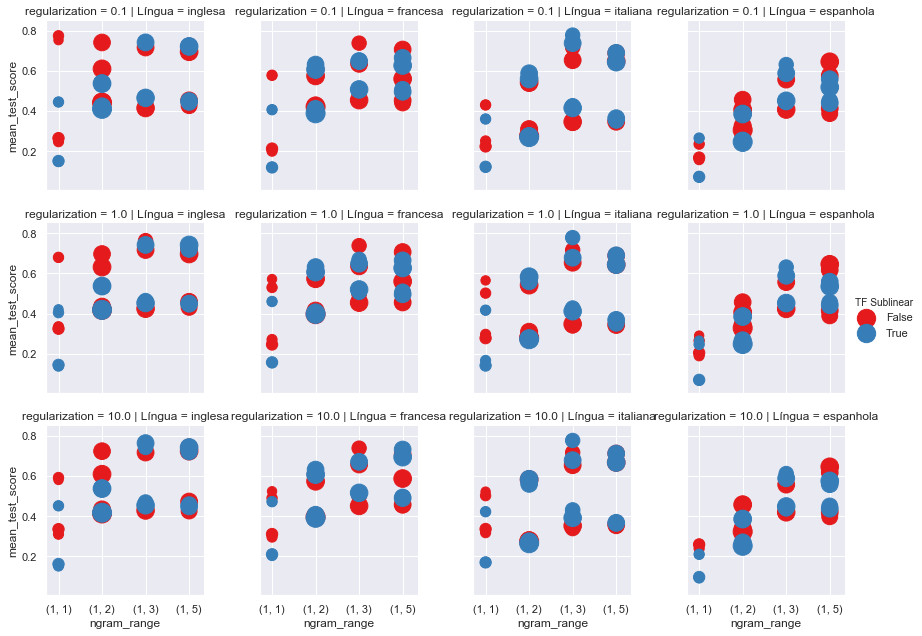

In [29]:
d = dfCV.copy()
d = d.rename(columns={'language':u'Língua', 'sublinear_tf':'TF Sublinear'})
d = d [ d.norm.isna() == False]
d['autorNumber'] = d.problem.map(lambda x: 20 if x % 2==0  else 5)
d.problem = d.apply(lambda x: x[u'Língua'] +" "+ str(x[u'problem']), axis=1)
#d.ngram_range = d.apply(lambda x: str(x[u'ngram_range'][0]) +" "+ str(x[u'ngram_range'][1]), axis=1)

d.std_test_score =d.std_test_score / d.std_test_score.quantile(0.95) *500;
d.std_test_score +=1;
d.std_test_score = d.std_test_score.astype(np.int64)
g = sns.FacetGrid(d, col='Língua', hue='TF Sublinear',  row="regularization", height=3,palette="Set1")
g.map(plt.scatter, "ngram_range", "mean_test_score",s=d.std_test_score.values).add_legend();
#sns.pairplot(d, hue="TF Sublinear", vars=["autorNumber", "mean_test_score"])


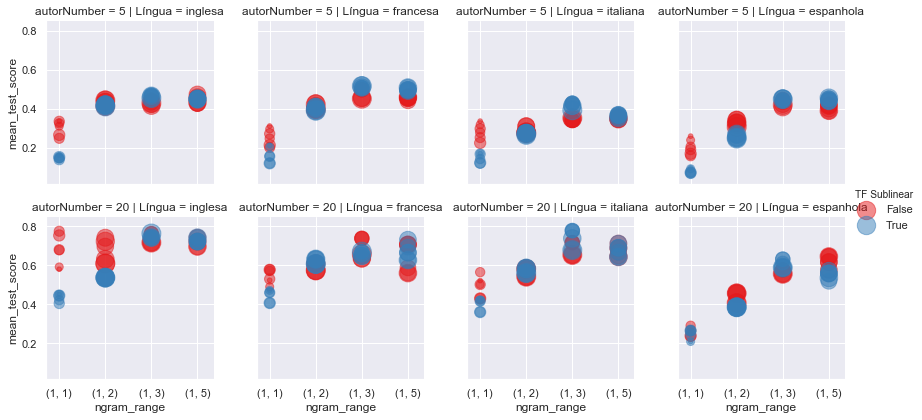

In [30]:
g = sns.FacetGrid(d, row='autorNumber', hue='TF Sublinear',  col=u"Língua", height=3,palette="Set1")
g.map(plt.scatter, "ngram_range", "mean_test_score", alpha=0.5, s=d.std_test_score.values).add_legend();

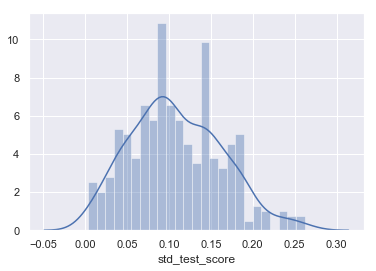

In [31]:
sns.distplot(dfCV.std_test_score, bins=25);

In [32]:
import statsmodels.api as sm

In [33]:
d = dfCV[['mean_test_score','problem', 'language','sublinear_tf','norm','ngram_range']].copy();
d.sublinear_tf=d.sublinear_tf.apply(lambda x: 1 if x else 0)
d.norm=d.norm.apply(lambda x: 1 if x=='l1' else 0)

d['autorNumber'] = d.problem.map(lambda x: 20 if x % 2==0  else 5)
d.norm.fillna(value='None', inplace=True);

_, d['ngram_max'] = zip(*d.ngram_range.str.replace(r'[^\d,]','').str.split(',').values.tolist())
#d.ngram_min = d.ngram_min.astype(np.uint8);
d.ngram_max = d.ngram_max.astype(np.uint8);
d.drop(columns=['ngram_range','problem'], inplace=True)
#d['intercept'] = 1;

d=pd.get_dummies(d, columns=['language'])

In [34]:
d.describe()

,mean_test_score,sublinear_tf,norm,autorNumber,ngram_max,language_espanhola,language_francesa,language_inglesa,language_italiana
count,384.0000,384.0000,384.0000,384.0000,384.0000,384.0000,384.0000,384.0000,384.0000
mean,0.4668,0.5000,0.5000,12.5000,2.7500,0.2500,0.2500,0.2500,0.2500
std,0.1695,0.5007,0.5007,7.5098,1.4809,0.4336,0.4336,0.4336,0.4336
min,0.0671,0.0000,0.0000,5.0000,1.0000,0.0000,0.0000,0.0000,0.0000
25%,0.3534,0.0000,0.0000,5.0000,1.7500,0.0000,0.0000,0.0000,0.0000
50%,0.4510,0.5000,0.5000,12.5000,2.5000,0.0000,0.0000,0.0000,0.0000
75%,0.5956,1.0000,1.0000,20.0000,3.5000,0.2500,0.2500,0.2500,0.2500
max,0.7783,1.0000,1.0000,20.0000,5.0000,1.0000,1.0000,1.0000,1.0000


In [35]:
mod = sm.OLS( d.iloc[:,0], d.iloc[:,1:])
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        mean_test_score   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     174.8
Date:                Wed, 06 Feb 2019   Prob (F-statistic):          4.59e-114
Time:                        18:32:38   Log-Likelihood:                 415.19
No. Observations:                 384   AIC:                            -814.4
Df Residuals:                     376   BIC:                            -782.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
sublinear_tf          -0.0285      0.008     -3.372      0.001      -0.045      -0.012
norm                   0.0053      0.008      0.628      0.530      -0.011       0.022
autorNumber            0.0152      0.001     26.871      0.000       0.014       0.016
ngram_max              0.0536      0.003     18.733      0.000       0.048       0.059
language_espanhola     0.0660      0.015      4.459      0.000       0.037       0.095
language_francesa      0.1760      0.015     11.885      0.000       0.147       0.205
language_inglesa       0.1953      0.015     13.193      0.000       0.166       0.224
language_italiana      0.1284      0.015      8.672      0.000       0.099       0.157
==============================================================================
Omnibus:                        1.873   Durbin-Watson:                   1.674
Prob(Omnibus):                  0.392   Jarque-Bera (JB):                1.634
Skew:                           0.014   Prob(JB):                        0.442
Kurtosis:                       2.682   Cond. No.                         91.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

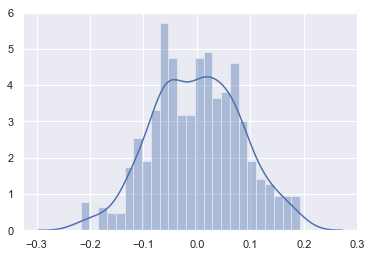

In [36]:
sns.distplot(res.predict()-d.iloc[:,0].values, bins=25)

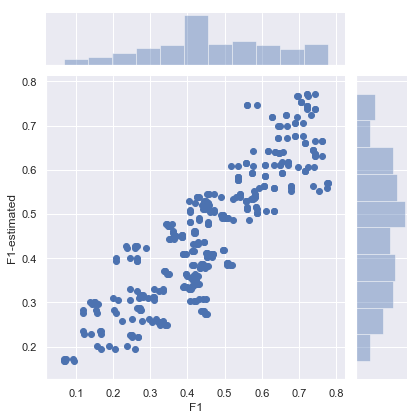

In [37]:
sns.jointplot(x='F1',y='F1-estimated',data=pd.DataFrame({'F1':d.iloc[:,0].values, 'F1-estimated':res.predict()}));

#  tests

In [38]:
problem = problems[0]
print ("\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']), end=' ');



Problem: problem00001,  language: en,  

In [49]:
def d(estimator, n_features=15):
    from IPython.display import Markdown, display, HTML
    names = np.array(estimator.named_steps['vect'].get_feature_names());
    classes_ = estimator.named_steps['clf'].classes_;
    weights = estimator.named_steps['clf'].coef_;
    
    def tag(tag, content, attrib=''):
        if attrib != '':
            attrib = ' style="' + attrib+'"'; 
        return ''.join(['<',tag,attrib,' >',content,'</',tag,'>']);
    
    def color(baseColor, intensity):
        r,g,b = baseColor[0:2],baseColor[2:4],baseColor[4:6]
        r,g,b = int(r, 16), int(g, 16), int(b, 16)
        
        f= (1-np.abs(intensity))/3;
        r = r + int((255-r)*f)
        g = g + int((255-g)*f)
        b = b + int((255-b)*f)
        rgb = '#%02x%x%x' % (r, g, b);
        #print(baseColor,rgb,r,g,b,intensity,f)
        return rgb
    
    
    spanStyle ='border-radius: 5px;margin:2px 4px;padding:2px; color:#FFF;display:inline-block;';
    
    lines = '<table>'+tag('thead',tag('th','Classes')+tag('th','positive')+tag('th','negative'))
    lines += '<tbody>'
    for i,c in enumerate(weights):
        c = np.round(c / np.abs(c).max(),2);
        positive = names[np.argsort(-c)][:n_features];
        positiveV = c[np.argsort(-c)][:n_features]
        negative = names[np.argsort(c)][:n_features];
        negativeV = c[np.argsort(c)][:n_features]
        
        lines += tag('tr',
                     tag('td', re.sub('\D0*','',classes_[i]))
                     + tag('td',''.join([tag('span',d.upper()+' '+str(v),spanStyle+'background:'+color('51A3DD',v)) for d,v in zip(positive,positiveV)]))
                     + tag('td',''.join([tag('span',d.upper()+' '+str(v),spanStyle+'background:'+color('DD5555',v)) for d,v in zip(negative,negativeV)]))
                    )
    lines+= '</tbody></table>'
        
    display(HTML(lines))
    #print(lines)
        
d(estimators[1])

1,AMOD 0.64ACOMP 0.33DEP 0.22ACL 0.21CSUBJ 0.13CASE 0.13CONJ 0.09COMPOUND 0.08NMOD 0.05DET 0.03NSUBJ 0.03CSUBJPASS 0.02DATIVE 0.02EXPL 0.01NSUBJPASS 0.01,ADVCL -1.0ROOT -0.75AGENT -0.29APPOS -0.26CCOMP -0.25AUXPASS -0.2CC -0.19DOBJ -0.08ATTR -0.07AUX -0.05INTJ -0.04ADVMOD -0.03NUMMOD -0.03MARK -0.01NPADVMOD -0.0
2,ROOT 1.0ACL 0.4ADVMOD 0.35ACOMP 0.2AUX 0.17AUXPASS 0.15AGENT 0.14COMPOUND 0.14DOBJ 0.1NEG 0.06AMOD 0.04EXPL 0.03CC 0.03NPADVMOD 0.02NUMMOD 0.01,CONJ -0.16CCOMP -0.11ADVCL -0.08APPOS -0.07CSUBJ -0.06NMOD -0.05MARK -0.05CASE -0.05DATIVE -0.05CSUBJPASS -0.05ATTR -0.04DEP -0.04DET -0.03NSUBJPASS -0.01NSUBJ -0.01
3,ADVCL 1.0ACL 0.53CCOMP 0.19ATTR 0.18CONJ 0.07NEG 0.07CSUBJPASS 0.07NSUBJPASS 0.03INTJ 0.03DET 0.02ADVMOD -0.0NPADVMOD -0.01OPRD -0.01AUXPASS -0.01NUMMOD -0.02,ROOT -0.87APPOS -0.27AUX -0.26CASE -0.17CSUBJ -0.16CC -0.13DATIVE -0.11NMOD -0.08ACOMP -0.08AMOD -0.07COMPOUND -0.07DEP -0.06MARK -0.05NSUBJ -0.03EXPL -0.03
4,ADVMOD 0.92AGENT 0.69APPOS 0.65CC 0.54AUXPASS 0.28CCOMP 0.27CSUBJ 0.23DATIVE 0.16MARK 0.13EXPL 0.12DEP 0.1NSUBJ 0.1NMOD 0.09NUMMOD 0.08DOBJ 0.08,ACL -1.0ROOT -0.76ACOMP -0.74AMOD -0.71ADVCL -0.46ATTR -0.41COMPOUND -0.4AUX -0.26CASE -0.21CONJ -0.15NEG -0.1NPADVMOD -0.07DET -0.04CSUBJPASS -0.04NSUBJPASS 0.01
5,ROOT 0.7ADVCL 0.27APPOS 0.27CASE 0.23AUX 0.23ATTR 0.17CONJ 0.15DATIVE 0.07MARK 0.06NMOD 0.05CCOMP 0.04COMPOUND 0.04DET 0.03NPADVMOD 0.03OPRD -0.01,ADVMOD -1.0ACL -0.75AGENT -0.31AMOD -0.18AUXPASS -0.18DEP -0.16NEG -0.09EXPL -0.08DOBJ -0.08ACOMP -0.07NSUBJ -0.05CC -0.04NSUBJPASS -0.03INTJ -0.02NUMMOD -0.02


In [40]:
%%HTML
<table><tbody><tr><th>POS</th><th>Description</th><th>Examples</th></tr><tr >
<td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text u-text-small">adjective</td><td class="c-table__cell u-text u-text-small"><em>big, old, green, incomprehensible, first</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>ADP</code></td><td class="c-table__cell u-text u-text-small">adposition</td><td class="c-table__cell u-text u-text-small"><em>in, to, during</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>ADV</code></td><td class="c-table__cell u-text u-text-small">adverb</td><td class="c-table__cell u-text u-text-small"><em>very, tomorrow, down, where, there</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>AUX</code></td><td class="c-table__cell u-text u-text-small">auxiliary</td><td class="c-table__cell u-text u-text-small"><em>is, has (done), will (do), should (do)</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>CONJ</code></td><td class="c-table__cell u-text u-text-small">conjunction</td><td class="c-table__cell u-text u-text-small"><em>and, or, but</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>CCONJ</code></td><td class="c-table__cell u-text u-text-small">coordinating conjunction</td><td class="c-table__cell u-text u-text-small"><em>and, or, but</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>DET</code></td><td class="c-table__cell u-text u-text-small">determiner</td><td class="c-table__cell u-text u-text-small"><em>a, an, the</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>INTJ</code></td><td class="c-table__cell u-text u-text-small">interjection</td><td class="c-table__cell u-text u-text-small"><em>psst, ouch, bravo, hello</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NOUN</code></td><td class="c-table__cell u-text u-text-small">noun</td><td class="c-table__cell u-text u-text-small"><em>girl, cat, tree, air, beauty</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NUM</code></td><td class="c-table__cell u-text u-text-small">numeral</td><td class="c-table__cell u-text u-text-small"><em>1, 2017, one, seventy-seven, IV, MMXIV</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PART</code></td><td class="c-table__cell u-text u-text-small">particle</td><td class="c-table__cell u-text u-text-small"><em>'s, not, </em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PRON</code></td><td class="c-table__cell u-text u-text-small">pronoun</td><td class="c-table__cell u-text u-text-small"><em>I, you, he, she, myself, themselves, somebody</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PROPN</code></td><td class="c-table__cell u-text u-text-small">proper noun</td><td class="c-table__cell u-text u-text-small"><em>Mary, John, London, NATO, HBO</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text u-text-small">punctuation</td><td class="c-table__cell u-text u-text-small"><em>., (, ), ?</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>SCONJ</code></td><td class="c-table__cell u-text u-text-small">subordinating conjunction</td><td class="c-table__cell u-text u-text-small"><em>if, while, that</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>SYM</code></td><td class="c-table__cell u-text u-text-small">symbol</td><td class="c-table__cell u-text u-text-small"><em>$, %, §, ©, +, −, ×, ÷, =, :), 😝</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text u-text-small">verb</td><td class="c-table__cell u-text u-text-small"><em>run, runs, running, eat, ate, eating</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>X</code></td><td class="c-table__cell u-text u-text-small">other</td><td class="c-table__cell u-text u-text-small"><em>sfpksdpsxmsa</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>SPACE</code></td><td class="c-table__cell u-text u-text-small">space</td></tr></tbody></table>

POS,Description,Examples
ADJ,adjective,"big, old, green, incomprehensible, first"
ADP,adposition,"in, to, during"
ADV,adverb,"very, tomorrow, down, where, there"
AUX,auxiliary,"is, has (done), will (do), should (do)"
CONJ,conjunction,"and, or, but"
CCONJ,coordinating conjunction,"and, or, but"
DET,determiner,"a, an, the"
INTJ,interjection,"psst, ouch, bravo, hello"
NOUN,noun,"girl, cat, tree, air, beauty"
NUM,numeral,"1, 2017, one, seventy-seven, IV, MMXIV"


In [41]:
%%HTML
<h1>English</h1>

<table class="c-table o-block"><tbody><tr class="c-table__row c-table__row--head"><th class="c-table__head-cell u-text-label">Tag</th><th class="c-table__head-cell u-text-label">POS</th><th class="c-table__head-cell u-text-label">Morphology</th><th class="c-table__head-cell u-text-label">Description</th></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>-LRB-</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=brck</code> <code>PunctSide=ini</code></td><td class="c-table__cell u-text u-text-small">left round bracket</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>-RRB-</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=brck</code> <code>PunctSide=fin</code></td><td class="c-table__cell u-text u-text-small">right round bracket</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>,</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=comm</code></td><td class="c-table__cell u-text u-text-small">punctuation mark, comma</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>:</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">punctuation mark, colon or ellipsis</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>.</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=peri</code></td><td class="c-table__cell u-text u-text-small">punctuation mark, sentence closer</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>''</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=quot</code> <code>PunctSide=fin</code></td><td class="c-table__cell u-text u-text-small">closing quotation mark</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>""</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=quot</code> <code>PunctSide=fin</code></td><td class="c-table__cell u-text u-text-small">closing quotation mark</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>#</code></td><td class="c-table__cell u-text"><code>SYM</code></td><td class="c-table__cell u-text"> <code>SymType=numbersign</code></td><td class="c-table__cell u-text u-text-small">symbol, number sign</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>``</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=quot</code> <code>PunctSide=ini</code></td><td class="c-table__cell u-text u-text-small">opening quotation mark</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>$</code></td><td class="c-table__cell u-text"><code>SYM</code></td><td class="c-table__cell u-text"> <code>SymType=currency</code></td><td class="c-table__cell u-text u-text-small">symbol, currency</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>ADD</code></td><td class="c-table__cell u-text"><code>X</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">email</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>AFX</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>Hyph=yes</code></td><td class="c-table__cell u-text u-text-small">affix</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>BES</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">auxiliary "be"</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>CC</code></td><td class="c-table__cell u-text"><code>CONJ</code></td><td class="c-table__cell u-text"> <code>ConjType=coor</code></td><td class="c-table__cell u-text u-text-small">conjunction, coordinating</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>CD</code></td><td class="c-table__cell u-text"><code>NUM</code></td><td class="c-table__cell u-text"> <code>NumType=card</code></td><td class="c-table__cell u-text u-text-small">cardinal number</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>DT</code></td><td class="c-table__cell u-text"><code>DET</code></td><td class="c-table__cell u-text"> <code>determiner</code></td><td class="c-table__cell u-text u-text-small"></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>EX</code></td><td class="c-table__cell u-text"><code>ADV</code></td><td class="c-table__cell u-text"> <code>AdvType=ex</code></td><td class="c-table__cell u-text u-text-small">existential there</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>FW</code></td><td class="c-table__cell u-text"><code>X</code></td><td class="c-table__cell u-text"> <code>Foreign=yes</code></td><td class="c-table__cell u-text u-text-small">foreign word</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>GW</code></td><td class="c-table__cell u-text"><code>X</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">additional word in multi-word expression</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>HVS</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">forms of "have"</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>HYPH</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=dash</code></td><td class="c-table__cell u-text u-text-small">punctuation mark, hyphen</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>IN</code></td><td class="c-table__cell u-text"><code>ADP</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">conjunction, subordinating or preposition</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>JJ</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>Degree=pos</code></td><td class="c-table__cell u-text u-text-small">adjective</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>JJR</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>Degree=comp</code></td><td class="c-table__cell u-text u-text-small">adjective, comparative</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>JJS</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>Degree=sup</code></td><td class="c-table__cell u-text u-text-small">adjective, superlative</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>LS</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>NumType=ord</code></td><td class="c-table__cell u-text u-text-small">list item marker</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>MD</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbType=mod</code></td><td class="c-table__cell u-text u-text-small">verb, modal auxiliary</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NFP</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">superfluous punctuation</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NIL</code></td><td class="c-table__cell u-text"><code></code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">missing tag</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NN</code></td><td class="c-table__cell u-text"><code>NOUN</code></td><td class="c-table__cell u-text"> <code>Number=sing</code></td><td class="c-table__cell u-text u-text-small">noun, singular or mass</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NNP</code></td><td class="c-table__cell u-text"><code>PROPN</code></td><td class="c-table__cell u-text"> <code>NounType=prop</code> <code>Number=sign</code></td><td class="c-table__cell u-text u-text-small">noun, proper singular</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NNPS</code></td><td class="c-table__cell u-text"><code>PROPN</code></td><td class="c-table__cell u-text"> <code>NounType=prop</code> <code>Number=plur</code></td><td class="c-table__cell u-text u-text-small">noun, proper plural</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NNS</code></td><td class="c-table__cell u-text"><code>NOUN</code></td><td class="c-table__cell u-text"> <code>Number=plur</code></td><td class="c-table__cell u-text u-text-small">noun, plural</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PDT</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>AdjType=pdt</code> <code>PronType=prn</code></td><td class="c-table__cell u-text u-text-small">predeterminer</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>POS</code></td><td class="c-table__cell u-text"><code>PART</code></td><td class="c-table__cell u-text"> <code>Poss=yes</code></td><td class="c-table__cell u-text u-text-small">possessive ending</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PRP</code></td><td class="c-table__cell u-text"><code>PRON</code></td><td class="c-table__cell u-text"> <code>PronType=prs</code></td><td class="c-table__cell u-text u-text-small">pronoun, personal</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PRP$</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>PronType=prs</code> <code>Poss=yes</code></td><td class="c-table__cell u-text u-text-small">pronoun, possessive</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>RB</code></td><td class="c-table__cell u-text"><code>ADV</code></td><td class="c-table__cell u-text"> <code>Degree=pos</code></td><td class="c-table__cell u-text u-text-small">adverb</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>RBR</code></td><td class="c-table__cell u-text"><code>ADV</code></td><td class="c-table__cell u-text"> <code>Degree=comp</code></td><td class="c-table__cell u-text u-text-small">adverb, comparative</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>RBS</code></td><td class="c-table__cell u-text"><code>ADV</code></td><td class="c-table__cell u-text"> <code>Degree=sup</code></td><td class="c-table__cell u-text u-text-small">adverb, superlative</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>RP</code></td><td class="c-table__cell u-text"><code>PART</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">adverb, particle</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>_SP</code></td><td class="c-table__cell u-text"><code>SPACE</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">space</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>SYM</code></td><td class="c-table__cell u-text"><code>SYM</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">symbol</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>TO</code></td><td class="c-table__cell u-text"><code>PART</code></td><td class="c-table__cell u-text"> <code>PartType=inf</code> <code>VerbForm=inf</code></td><td class="c-table__cell u-text u-text-small">infinitival to</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>UH</code></td><td class="c-table__cell u-text"><code>INTJ</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">interjection</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VB</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbForm=inf</code></td><td class="c-table__cell u-text u-text-small">verb, base form</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VBD</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbForm=fin</code> <code>Tense=past</code></td><td class="c-table__cell u-text u-text-small">verb, past tense</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VBG</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbForm=part</code> <code>Tense=pres</code> <code>Aspect=prog</code></td><td class="c-table__cell u-text u-text-small">verb, gerund or present participle</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VBN</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbForm=part</code> <code>Tense=past</code> <code>Aspect=perf</code></td><td class="c-table__cell u-text u-text-small">verb, past participle</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VBP</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbForm=fin</code> <code>Tense=pres</code></td><td class="c-table__cell u-text u-text-small">verb, non-3rd person singular present</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VBZ</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbForm=fin</code> <code>Tense=pres</code> <code>Number=sing</code> <code>Person=3</code></td><td class="c-table__cell u-text u-text-small">verb, 3rd person singular present</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>WDT</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>PronType=int</code> <code>rel</code></td><td class="c-table__cell u-text u-text-small">wh-determiner</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>WP</code></td><td class="c-table__cell u-text"><code>NOUN</code></td><td class="c-table__cell u-text"> <code>PronType=int</code> <code>rel</code></td><td class="c-table__cell u-text u-text-small">wh-pronoun, personal</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>WP$</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>Poss=yes PronType=int</code> <code>rel</code></td><td class="c-table__cell u-text u-text-small">wh-pronoun, possessive</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>WRB</code></td><td class="c-table__cell u-text"><code>ADV</code></td><td class="c-table__cell u-text"> <code>PronType=int</code> <code>rel</code></td><td class="c-table__cell u-text u-text-small">wh-adverb</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>XX</code></td><td class="c-table__cell u-text"><code>X</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">unknown</td></tr></tbody></table>

Tag,POS,Morphology,Description
-LRB-,PUNCT,PunctType=brck PunctSide=ini,left round bracket
-RRB-,PUNCT,PunctType=brck PunctSide=fin,right round bracket
",",PUNCT,PunctType=comm,"punctuation mark, comma"
:,PUNCT,,"punctuation mark, colon or ellipsis"
.,PUNCT,PunctType=peri,"punctuation mark, sentence closer"
'',PUNCT,PunctType=quot PunctSide=fin,closing quotation mark
"""""",PUNCT,PunctType=quot PunctSide=fin,closing quotation mark
#,SYM,SymType=numbersign,"symbol, number sign"
``,PUNCT,PunctType=quot PunctSide=ini,opening quotation mark
$,SYM,SymType=currency,"symbol, currency"
